### Imports

In [198]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

### Data Collection

In [251]:
# https://www.basketball-reference.com/leagues/NBA_2019_standings.html
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [200]:
# Stats on the teams per season
df = pd.read_csv('NBA_Data.csv')
# df

In [201]:
# CSV file that has the list of teams that won the playoffs per season
dfPlayOffs = pd.read_csv('NBA_PLAYOFFS.csv')
# dfPlayOffs

In [202]:
# CSV file that has the list of game stats for each team per season
dfGameStats = pd.read_csv('NBA_GAMESTAT.csv')
# dfGameStats

### Data Cleaning

Dropping/renaming certain columns that are not useful. Also grabbing only the teams that were in first round of playoffs

In [203]:
# Also remove the rank col since it is not really helpful
df.drop(columns=['Rk'],inplace=True)
dfGameStats.drop(columns=['Rk'],inplace=True)

# Rename the column so it can be accessed easier
df.rename(columns={"≤3": "<=3", "≥10": ">=10", "E": "East", "W": "West", "Pre": "PreAllStar", "Post": "PostAllStar"}, inplace=True)

# ----------------------------------------------------------------------------------------------------------------

# Rename some column names 
dfPlayOffs.rename(columns={"Yr": "Season", "Team": "TeamW", "Team.1": "TeamL"}, inplace=True)

# Get all teams that were in FirstRound
dfFirstRound = dfPlayOffs[(dfPlayOffs.Series == 'Eastern Conf First Round') | (dfPlayOffs.Series == 'Western Conf First Round')]
dfFirstRound = dfFirstRound.reset_index(drop=True)

# dfFirstRound

Keeping the teams that were in the playoffs for that season (df the original overall stat)

In [204]:
dfNew = pd.DataFrame(columns = ['Team','Season','Overall','Home','Road','East','West','PreAllStar','PostAllStar','<=3','>=10','Dec','Jan','Feb','Mar'])

# Comparing the season year and the teams that were in playoffs and using those data only
for i in range(len(df)):
    for j in range(len(dfFirstRound)):
        if ((df.loc[i, "Season"] == dfFirstRound.loc[j, "Season"]) and 
            ((df.loc[i, "Team"] == dfFirstRound.loc[j, "TeamW"]) or 
             (df.loc[i, "Team"] == dfFirstRound.loc[j, "TeamL"]))):
            dfNew = dfNew.append({'Team': df.loc[i, "Team"], 'Season': df.loc[i, "Season"], 'Overall': df.loc[i, "Overall"], 
                                  'Home': df.loc[i, "Home"], 'Road': df.loc[i, "Road"],
                                  'East': df.loc[i, "East"], 'West': df.loc[i, "West"],
                                  'PreAllStar': df.loc[i, "PreAllStar"],'PostAllStar': df.loc[i, "PostAllStar"], 
                                  '<=3': df.loc[i, "<=3"], '>=10': df.loc[i, ">=10"],
                                  'Dec': df.loc[i, "Dec"], 'Jan': df.loc[i, "Jan"], 
                                  'Feb': df.loc[i, "Feb"], 'Mar': df.loc[i, "Mar"]}, ignore_index = True)

# dfNew

Keeping the teams that were in the playoffs for that season (dfGameStat the game stat)

In [205]:
dfStat = pd.DataFrame(columns = ['Team','Season','FG','FGA','FG%','3P','3PA','3P%','2P','2PA',
                                 '2P%','FT','FTA','FT%','ORB','DRB','TRB','AST','STL',
                                 'BLK','TOV','PF','PTS'])

# Comparing the season year and the teams that were in playoffs and using those data only
for i in range(len(dfGameStats)):
    for j in range(len(dfFirstRound)):
        if ((dfGameStats.loc[i, "Season"] == dfFirstRound.loc[j, "Season"]) and 
            ((dfGameStats.loc[i, "Team"] == dfFirstRound.loc[j, "TeamW"]) or 
             (dfGameStats.loc[i, "Team"] == dfFirstRound.loc[j, "TeamL"]))):
            dfStat = dfStat.append({'Team': dfGameStats.loc[i, "Team"], 'Season': dfGameStats.loc[i, "Season"],
                                    'FG': dfGameStats.loc[i, "FG"], 'FGA': dfGameStats.loc[i, "FGA"],
                                    'FG%': dfGameStats.loc[i, "FG%"], '3P': dfGameStats.loc[i, "3P"],
                                    '3PA': dfGameStats.loc[i, "3PA"], '3P%': dfGameStats.loc[i, "3P%"],
                                    '2P': dfGameStats.loc[i, "2P"], '2PA': dfGameStats.loc[i, "2PA"],
                                    '2P%': dfGameStats.loc[i, "2P%"], 'FT': dfGameStats.loc[i, "FT"],
                                    'FTA': dfGameStats.loc[i, "FTA"], 'FT%': dfGameStats.loc[i, "FT%"],
                                    'ORB': dfGameStats.loc[i, "ORB"], 'DRB': dfGameStats.loc[i, "DRB"],
                                    'TRB': dfGameStats.loc[i, "TRB"], 'AST': dfGameStats.loc[i, "AST"],
                                    'STL': dfGameStats.loc[i, "STL"], 'BLK': dfGameStats.loc[i, "BLK"],
                                    'TOV': dfGameStats.loc[i, "TOV"], 'PF': dfGameStats.loc[i, "PF"],
                                    'PTS': dfGameStats.loc[i, "PTS"]}, ignore_index = True)

# dfStat

Converts the format of columns from win-loss to a percentage for better reading

In [206]:
def convertToPct(data):
    arr = data.split('-')
    win = arr[0]
    loss = arr[1]
    pct = int(win)/(int(win)+int(loss))
    return round(pct,3)

# Convert each column values to percentage for better training purposes
for column in dfNew[['Overall','Home','Road','East','West','PreAllStar','PostAllStar','<=3','>=10','Dec','Jan','Feb','Mar']]:
    dfNew[column] = dfNew[column].apply(lambda x: convertToPct(x))

# dfNew

# Classifier functions

In [207]:
def dTreeClassifier(X_train,X_test,y_train,y_test):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    clf_pred = clf.predict(X_test)

    print('Decision Classifier', clf_pred,'\n')
    print('Decision Classifier Accuracy Score', accuracy_score(y_test, clf_pred))
    print('Mean square error: %.2f'% mean_squared_error(y_test, clf_pred),'\n')

    print(classification_report(y_test, clf_pred))

In [208]:
def knnClassifier(X_train,X_test,y_train,y_test,k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    neigh_pred = neigh.predict(X_test)

    print(f'{k}-NN Classifier:', neigh_pred,'\n')
    print(f'{k}-NN Accuracy Score:', accuracy_score(y_test, neigh_pred))
    print('Mean square error: %.2f'% mean_squared_error(y_test, neigh_pred),'\n')

    print(classification_report(y_test, neigh_pred),'\n')
    print("------------------------------------------------------------\n")

In [209]:
def naiveClassifier(X_train,X_test,y_train,y_test):
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    gnb_pred = gnb.predict(X_test)

    print('Naive Bayes Classifier:', gnb_pred,'\n')
    print('Naive Bayes Accuracy Score:', accuracy_score(y_test, gnb_pred))
    print('Mean square error: %.2f'% mean_squared_error(y_test, gnb_pred),'\n')

    print(classification_report(y_test, gnb_pred))

# Multi-label classification (Using the Win Percentages for each attribute)

We want to add class label to each row classifying which team made it passed first round in playoffs (1) and 0 for losing team

In [210]:
# make label column and initilize it to 0
dfNew['label'] = 0

# Go thru each row and change the label to 1 if that team has passed the first round in playoffs
for i in range(len(dfNew)):
    for j in range(len(dfFirstRound)):
        if dfNew.loc[i, 'Team'] == dfFirstRound.loc[j, 'TeamW'] and dfNew.loc[i, 'Season'] == dfFirstRound.loc[j, 'Season']:
            dfNew.loc[i, 'label'] = 1

# dfNew.head(33)

#### Split dataset into training set and test set

In [211]:
# Test data contains season 2015-2020 and Train data contains season 1990-1998, 2000-2014
X_train = dfNew.values[:400,2:-1]
X_test = dfNew.values[400:,2:-1]
y_train = dfNew.label[:400]
y_test = dfNew.label[400:]


#### Heatmap for the dfNew

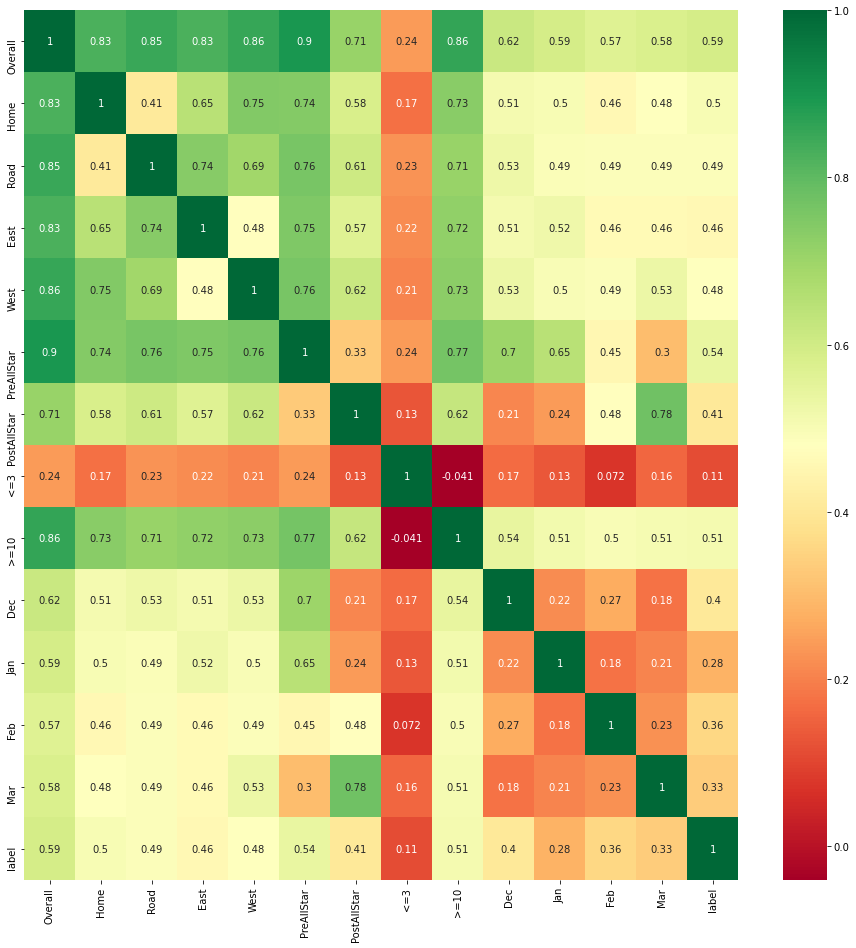

In [212]:
fig = plt.figure(figsize=(16, 16))

fig.set_facecolor('white')

sns.heatmap(dfNew.corr(), annot=True, cmap="RdYlGn")

#### Linear Regression

In [213]:
linearReg = LinearRegression()
linearReg.fit(X_train, y_train)
lin_pred = linearReg.predict(X_test)

print('Mean square error using all features: %.2f'% mean_squared_error(y_test, lin_pred))


Mean square error using all features: 0.13


Mean squared error using 1 feature: 0.14
RFE Ranking for 1 feature:  [ 1  3  2  5  4  6 12 10  9 11  7 13  8]


Mean squared error using 2 feature: 0.14
RFE Ranking for 2 feature:  [ 1  2  1  4  3  5 11  9  8 10  6 12  7]


Mean squared error using 3 feature: 0.13
RFE Ranking for 3 feature:  [ 1  1  1  3  2  4 10  8  7  9  5 11  6]


Mean squared error using 4 feature: 0.13
RFE Ranking for 4 feature:  [ 1  1  1  2  1  3  9  7  6  8  4 10  5]


Mean squared error using 5 feature: 0.13
RFE Ranking for 5 feature:  [1 1 1 1 1 2 8 6 5 7 3 9 4]


Mean squared error using 6 feature: 0.13
RFE Ranking for 6 feature:  [1 1 1 1 1 1 7 5 4 6 2 8 3]


Mean squared error using 7 feature: 0.13
RFE Ranking for 7 feature:  [1 1 1 1 1 1 6 4 3 5 1 7 2]


Mean squared error using 8 feature: 0.13
RFE Ranking for 8 feature:  [1 1 1 1 1 1 5 3 2 4 1 6 1]


Mean squared error using 9 feature: 0.13
RFE Ranking for 9 feature:  [1 1 1 1 1 1 4 2 1 3 1 5 1]


Mean squared error using 10 feature: 0.13
RFE Ranking for

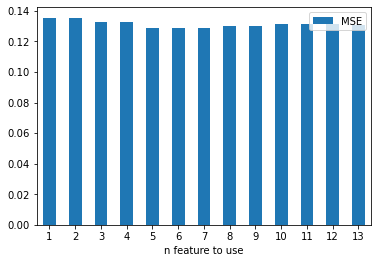

In [214]:
mseLst = []
rankingLst = []
for i in range(1,len(X_train[0])+1):
    rfe = RFE(estimator = linearReg , n_features_to_select = i , step = 1)
    rfe.fit(X_train, y_train)
    pred = rfe.predict(X_test)
    print('Mean squared error using %.0f feature: %.2f'% (i, mean_squared_error(y_test, pred)))
    print('RFE Ranking for', i, 'feature: ', rfe.ranking_)
    mseLst.append(mean_squared_error(y_test, pred))
    rankingLst.append(rfe.ranking_)
    print('\n')

label = ['1','2','3','4','5','6','7','8','9','10','11','12','13']
df = pd.DataFrame({'n feature to use':label, 'MSE':mseLst})
ax = df.plot.bar(x='n feature to use', y='MSE', rot=0)

#### Decision Tree Classifier

In [215]:
dTreeClassifier(X_train,X_test,y_train,y_test)

Decision Classifier [1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0
 1 1 0 0 0 0] 

Decision Classifier Accuracy Score 0.7
Mean square error: 0.30 

              precision    recall  f1-score   support

           0       0.66      0.82      0.73        40
           1       0.77      0.57      0.66        40

    accuracy                           0.70        80
   macro avg       0.71      0.70      0.70        80
weighted avg       0.71      0.70      0.70        80



#### KNN Classifier

In [216]:
# 3-NN
knnClassifier(X_train,X_test,y_train,y_test,3)

# 5-NN
knnClassifier(X_train,X_test,y_train,y_test,5)

# 7-NN
knnClassifier(X_train,X_test,y_train,y_test,7)

3-NN Classifier: [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1
 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0
 0 0 0 0 0 0] 

3-NN Accuracy Score: 0.8375
Mean square error: 0.16 

              precision    recall  f1-score   support

           0       0.79      0.93      0.85        40
           1       0.91      0.75      0.82        40

    accuracy                           0.84        80
   macro avg       0.85      0.84      0.84        80
weighted avg       0.85      0.84      0.84        80
 

------------------------------------------------------------

5-NN Classifier: [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1
 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0
 0 0 0 0 0 0] 

5-NN Accuracy Score: 0.7875
Mean square error: 0.21 

              precision    recall  f1-score   support

           0       0.73      0.90      0.81        40
           1       0.87   

#### Naive Bayes Classifier

In [217]:
naiveClassifier(X_train,X_test,y_train,y_test)

Naive Bayes Classifier: [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1
 0 0 0 0 0 0] 

Naive Bayes Accuracy Score: 0.8125
Mean square error: 0.19 

              precision    recall  f1-score   support

           0       0.76      0.93      0.83        40
           1       0.90      0.70      0.79        40

    accuracy                           0.81        80
   macro avg       0.83      0.81      0.81        80
weighted avg       0.83      0.81      0.81        80



# Multi-label classification (Using the Team Game Stats for each attribute)

We want to add class label to each row classifying which team made it passed first round in playoffs (1) and 0 for losing team

In [218]:
# make label column and initilize it to 0
dfStat['label'] = 0

# Go thru each row and change the label to 1 if that team has passed the first round in playoffs
for i in range(len(dfStat)):
    for j in range(len(dfFirstRound)):
        if dfStat.loc[i, 'Team'] == dfFirstRound.loc[j, 'TeamW'] and dfStat.loc[i, 'Season'] == dfFirstRound.loc[j, 'Season']:
            dfStat.loc[i, 'label'] = 1

# dfStat

Split dataset into training set and test set

In [219]:
# Test data contains season 2015-2020 and Train data contains season 1990-1998, 2000-2014
X_train = dfStat.values[:400,2:-1]
X_test = dfStat.values[400:,2:-1]
y_train = dfStat.label[:400]
y_test = dfStat.label[400:]


#### Heatmap for dfStat

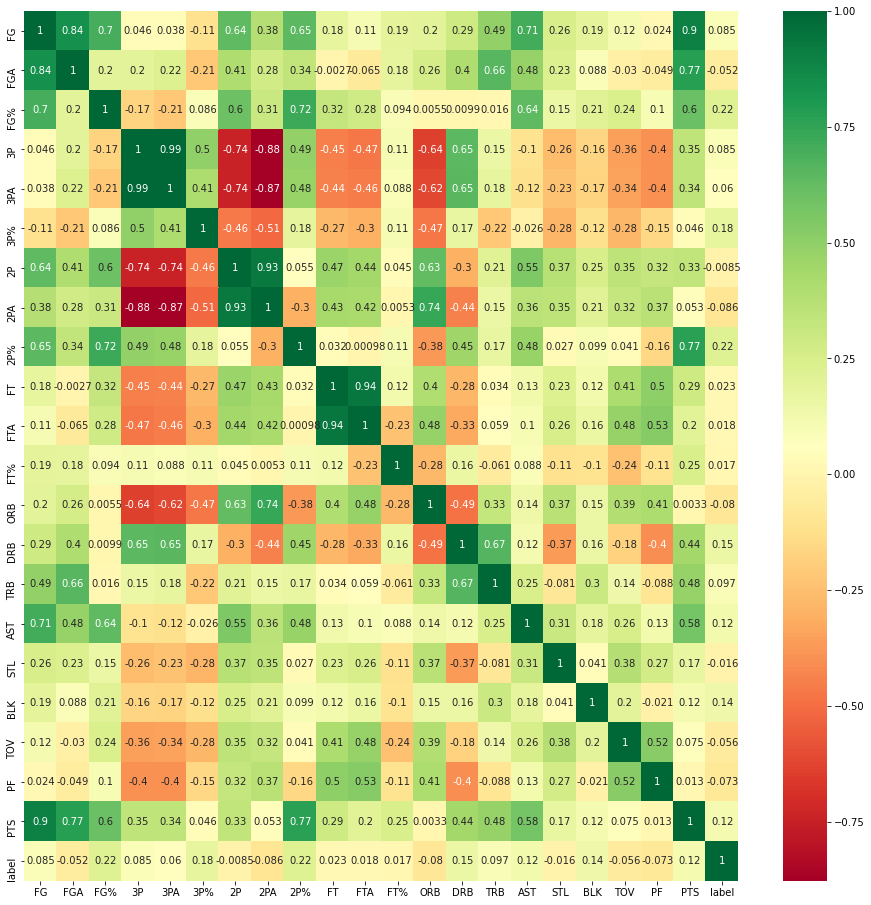

In [220]:
fig = plt.figure(figsize=(16, 16))

fig.set_facecolor('white')

sns.heatmap(dfStat.corr(), annot=True, cmap="RdYlGn")

#### Linear Regression

In [221]:
linearReg = LinearRegression()
linearReg.fit(X_train, y_train)
lin_pred = linearReg.predict(X_test)

print('Mean square error using all features: %.2f'% mean_squared_error(y_test, lin_pred))


Mean square error using all features: 0.23


Mean squared error using 1 feature: 0.23
RFE Ranking for 1 feature:  [ 7 17  2  3 12  8  4 13  1  5 21 14 10  9 11 19 15 18 16 20  6]


Mean squared error using 2 feature: 0.22
RFE Ranking for 2 feature:  [ 6 16  1  2 11  7  3 12  1  4 20 13  9  8 10 18 14 17 15 19  5]


Mean squared error using 3 feature: 0.24
RFE Ranking for 3 feature:  [ 5 15  1  1 10  6  2 11  1  3 19 12  8  7  9 17 13 16 14 18  4]


Mean squared error using 4 feature: 0.23
RFE Ranking for 4 feature:  [ 4 14  1  1  9  5  1 10  1  2 18 11  7  6  8 16 12 15 13 17  3]


Mean squared error using 5 feature: 0.23
RFE Ranking for 5 feature:  [ 3 13  1  1  8  4  1  9  1  1 17 10  6  5  7 15 11 14 12 16  2]


Mean squared error using 6 feature: 0.25
RFE Ranking for 6 feature:  [ 2 12  1  1  7  3  1  8  1  1 16  9  5  4  6 14 10 13 11 15  1]


Mean squared error using 7 feature: 0.24
RFE Ranking for 7 feature:  [ 1 11  1  1  6  2  1  7  1  1 15  8  4  3  5 13  9 12 10 14  1]


Mean squared error using 8 feature: 0.24
RFE Ran

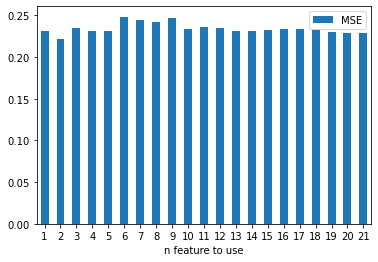

In [222]:
mseLst = []
rankingLst = []
for i in range(1,len(X_train[0])+1):
    rfe = RFE(estimator = linearReg , n_features_to_select = i , step = 1)
    rfe.fit(X_train, y_train)
    pred = rfe.predict(X_test)
    print('Mean squared error using %.0f feature: %.2f'% (i, mean_squared_error(y_test, pred)))
    print('RFE Ranking for', i, 'feature: ', rfe.ranking_)
    mseLst.append(mean_squared_error(y_test, pred))
    rankingLst.append(rfe.ranking_)
    print('\n')

label = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21']
df = pd.DataFrame({'n feature to use':label, 'MSE':mseLst})
ax = df.plot.bar(x='n feature to use', y='MSE', rot=0)

#### Decision Tree Classifier

In [223]:
dTreeClassifier(X_train,X_test,y_train,y_test)

Decision Classifier [1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1
 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0
 1 0 1 1 0 0] 

Decision Classifier Accuracy Score 0.6375
Mean square error: 0.36 

              precision    recall  f1-score   support

           0       0.66      0.57      0.61        40
           1       0.62      0.70      0.66        40

    accuracy                           0.64        80
   macro avg       0.64      0.64      0.64        80
weighted avg       0.64      0.64      0.64        80



#### KNN Classifier

In [224]:
# 3-NN
knnClassifier(X_train,X_test,y_train,y_test,3)

# 5-NN
knnClassifier(X_train,X_test,y_train,y_test,5)

# 7-NN
knnClassifier(X_train,X_test,y_train,y_test,7)

3-NN Classifier: [1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1
 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1] 

3-NN Accuracy Score: 0.6
Mean square error: 0.40 

              precision    recall  f1-score   support

           0       0.70      0.35      0.47        40
           1       0.57      0.85      0.68        40

    accuracy                           0.60        80
   macro avg       0.63      0.60      0.57        80
weighted avg       0.63      0.60      0.57        80
 

------------------------------------------------------------

5-NN Classifier: [1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1
 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0] 

5-NN Accuracy Score: 0.6625
Mean square error: 0.34 

              precision    recall  f1-score   support

           0       0.78      0.45      0.57        40
           1       0.61      

#### Naive Bayes Classifier

In [225]:
naiveClassifier(X_train,X_test,y_train,y_test)

Naive Bayes Classifier: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1] 

Naive Bayes Accuracy Score: 0.5125
Mean square error: 0.49 

              precision    recall  f1-score   support

           0       1.00      0.03      0.05        40
           1       0.51      1.00      0.67        40

    accuracy                           0.51        80
   macro avg       0.75      0.51      0.36        80
weighted avg       0.75      0.51      0.36        80



# Using both tables best features

In [226]:
# combines both the tables
dfCombined = pd.merge(dfNew, dfStat,  how='left', left_on=['Season','Team','label'], right_on = ['Season','Team','label'])

# drop the columns that arent helpful using the heatmap and classifer above
dfCombined.drop(columns=['<=3','Dec','Jan','Feb','Mar','FG','FGA','3P','3PA','3P%','2P','2PA',
                                 'FT','FTA','FT%','ORB','DRB','TRB','AST','STL',
                                 'BLK','TOV','PF','PTS'],inplace=True)

# reorder the column so label is last
dfCombined = dfCombined[['Team','Season','Overall','Home','Road','East','West','PreAllStar','PostAllStar','>=10','FG%','2P%','label']]



Split dataset into training set and test set

In [227]:
# Test data contains season 2015-2020 and Train data contains season 1990-1998, 2000-2014
X_train = dfCombined.values[:400,2:-1]
X_test = dfCombined.values[400:,2:-1]
y_train = dfCombined.label[:400]
y_test = dfCombined.label[400:]


#### Decision Tree Classifier

In [228]:
dTreeClassifier(X_train,X_test,y_train,y_test)

Decision Classifier [1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1
 0 1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0] 

Decision Classifier Accuracy Score 0.725
Mean square error: 0.28 

              precision    recall  f1-score   support

           0       0.69      0.82      0.75        40
           1       0.78      0.62      0.69        40

    accuracy                           0.73        80
   macro avg       0.73      0.72      0.72        80
weighted avg       0.73      0.72      0.72        80



#### KNN Classifier

In [229]:
# 3-NN
knnClassifier(X_train,X_test,y_train,y_test,3)

# 5-NN
knnClassifier(X_train,X_test,y_train,y_test,5)

# 7-NN
knnClassifier(X_train,X_test,y_train,y_test,7)


3-NN Classifier: [1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1
 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0] 

3-NN Accuracy Score: 0.7625
Mean square error: 0.24 

              precision    recall  f1-score   support

           0       0.71      0.90      0.79        40
           1       0.86      0.62      0.72        40

    accuracy                           0.76        80
   macro avg       0.78      0.76      0.76        80
weighted avg       0.78      0.76      0.76        80
 

------------------------------------------------------------

5-NN Classifier: [1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0
 0 0 0 0 0 0] 

5-NN Accuracy Score: 0.7375
Mean square error: 0.26 

              precision    recall  f1-score   support

           0       0.68      0.90      0.77        40
           1       0.85   

#### Naive Bayes Classifier

In [230]:
naiveClassifier(X_train,X_test,y_train,y_test)

Naive Bayes Classifier: [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0] 

Naive Bayes Accuracy Score: 0.825
Mean square error: 0.17 

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        40
           1       0.84      0.80      0.82        40

    accuracy                           0.82        80
   macro avg       0.83      0.82      0.82        80
weighted avg       0.83      0.82      0.82        80



# Try adding more labels to classify which teams made it to which round

label 0 = If team lost the conf first round

label 1 =  If team won the conf first round

label 2 = If team won the conf semi final 

label 3 = If team won the conf finals

label 4 = They won finals.

In [231]:
dfFinals = dfNew

# give the correct labels to the teams that passed each round
k = 0
while (k != 5):
    # If team lost the conf first round
    if k == 0:
        for i in range(len(dfFinals)):
            for j in range(len(dfPlayOffs)):
                if (dfFinals.loc[i, 'Team'] != dfPlayOffs.loc[j, 'TeamW']) and (dfFinals.loc[i, 'Season'] == dfPlayOffs.loc[j, 'Season']) and ((dfPlayOffs.loc[j, 'Series'] == 'Eastern Conf First Round') or (dfPlayOffs.loc[j, 'Series'] == 'Western Conf First Round')):
                    dfFinals.loc[i, 'label'] = 0
                    
    # If team won the conf first round
    elif k == 1:
        for i in range(len(dfFinals)):
            for j in range(len(dfPlayOffs)):
                if (dfFinals.loc[i, 'Team'] == dfPlayOffs.loc[j, 'TeamW']) and (dfFinals.loc[i, 'Season'] == dfPlayOffs.loc[j, 'Season']) and ((dfPlayOffs.loc[j, 'Series'] == 'Eastern Conf First Round') or (dfPlayOffs.loc[j, 'Series'] == 'Western Conf First Round')):
                    dfFinals.loc[i, 'label'] = 1
  
    # If team won the conf semi final 
    elif k == 2:
        for i in range(len(dfFinals)):
            for j in range(len(dfPlayOffs)):
                if (dfFinals.loc[i, 'Team'] == dfPlayOffs.loc[j, 'TeamW']) and (dfFinals.loc[i, 'Season'] == dfPlayOffs.loc[j, 'Season']) and ((dfPlayOffs.loc[j, 'Series'] == 'Eastern Conf Semifinals') or (dfPlayOffs.loc[j, 'Series'] == 'Western Conf Semifinals')):
                    dfFinals.loc[i, 'label'] = 2
    
    # If team won the conf finals
    elif k == 3:
        for i in range(len(dfFinals)):
            for j in range(len(dfPlayOffs)):
                if (dfFinals.loc[i, 'Team'] == dfPlayOffs.loc[j, 'TeamW']) and (dfFinals.loc[i, 'Season'] == dfPlayOffs.loc[j, 'Season']) and ((dfPlayOffs.loc[j, 'Series'] == 'Eastern Conf Finals') or (dfPlayOffs.loc[j, 'Series'] == 'Western Conf Finals')):
                    dfFinals.loc[i, 'label'] = 3
                    
    elif k == 4:
        for i in range(len(dfFinals)):
            for j in range(len(dfPlayOffs)):
                if (dfFinals.loc[i, 'Team'] == dfPlayOffs.loc[j, 'TeamW']) and (dfFinals.loc[i, 'Season'] == dfPlayOffs.loc[j, 'Season']) and ((dfPlayOffs.loc[j, 'Series'] == 'Finals') or (dfPlayOffs.loc[j, 'Series'] == 'Finals')):
                    dfFinals.loc[i, 'label'] = 4
    
    k+=1

# dfFinals

In [246]:
# Test data contains season 2015-2020 and Train data contains season 1990-1998, 2000-2014
X_train = dfFinals.values[:448,2:-1]
X_test = dfFinals.values[448:,2:-1]
y_train = dfFinals.label[:448]
y_test = dfFinals.label[448:]


#### Heatmap for dfFinals

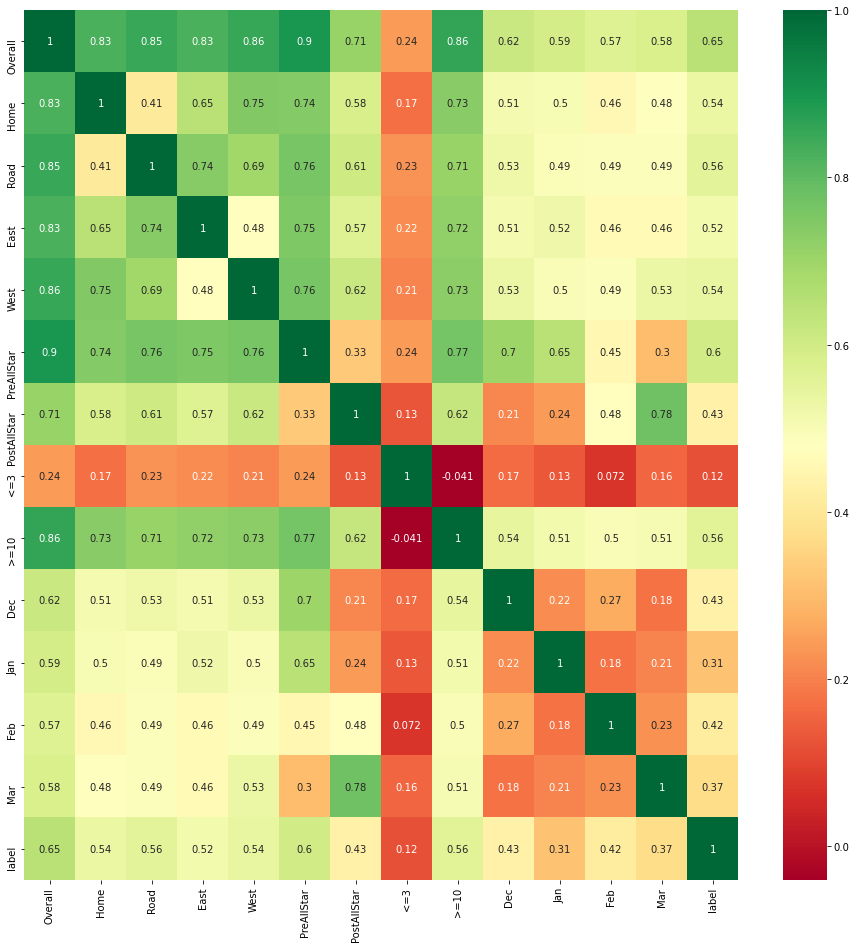

In [252]:
fig = plt.figure(figsize=(16, 16))

fig.set_facecolor('white')

sns.heatmap(dfFinals.corr(), annot=True, cmap="RdYlGn")

#### Decision Tree Classifier

In [247]:
dTreeClassifier(X_train,X_test,y_train,y_test)

Decision Classifier [4 3 3 1 1 0 0 0 1 0 3 0 1 0 0 0 4 2 2 0 0 1 0 1 0 1 2 0 0 0 0 0] 

Decision Classifier Accuracy Score 0.53125
Mean square error: 1.69 

              precision    recall  f1-score   support

           0       0.71      0.75      0.73        16
           1       0.57      0.50      0.53         8
           2       0.00      0.00      0.00         4
           3       0.33      0.50      0.40         2
           4       0.00      0.00      0.00         2

    accuracy                           0.53        32
   macro avg       0.32      0.35      0.33        32
weighted avg       0.52      0.53      0.52        32



#### Naive Bayes Classifier

In [249]:
naiveClassifier(X_train,X_test,y_train,y_test)

Naive Bayes Classifier: [4 2 2 1 2 2 1 1 0 0 0 0 0 0 0 0 4 2 2 2 3 1 1 0 0 1 1 0 0 0 0 0] 

Naive Bayes Accuracy Score: 0.46875
Mean square error: 1.31 

              precision    recall  f1-score   support

           0       0.80      0.75      0.77        16
           1       0.29      0.25      0.27         8
           2       0.14      0.25      0.18         4
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2

    accuracy                           0.47        32
   macro avg       0.25      0.25      0.24        32
weighted avg       0.49      0.47      0.48        32



#### KNN Classifier

In [248]:
# 3-NN
knnClassifier(X_train,X_test,y_train,y_test,3)

# 5-NN
knnClassifier(X_train,X_test,y_train,y_test,5)

# 7-NN
knnClassifier(X_train,X_test,y_train,y_test,7)


3-NN Classifier: [1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0] 

3-NN Accuracy Score: 0.5625
Mean square error: 2.00 

              precision    recall  f1-score   support

           0       0.58      0.88      0.70        16
           1       0.50      0.50      0.50         8
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2

    accuracy                           0.56        32
   macro avg       0.22      0.28      0.24        32
weighted avg       0.42      0.56      0.48        32
 

------------------------------------------------------------

5-NN Classifier: [2 0 2 0 1 0 0 2 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0] 

5-NN Accuracy Score: 0.5625
Mean square error: 1.78 

              precision    recall  f1-score   support

           0       0.58      0.88      0.70        16
           1       0.60      0.38      0.46         8
      

/Users/shalinpatel/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shalinpatel/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shalinpatel/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
